# Machine Vision
## Assignment 6 - Motion

## Personal details

* **Name(s):** `PUT YOUR NAME(S) HERE.`
* **Student ID(s):** `PUT YOUR STUDENT ID(S) HERE.`

## Background subtraction

In this assignment, we use a background subtraction technique to detect moving objects in a video. We use a dynamic background model that is continuously updated and threshold every frame of the video to detect new objects.

![detection.jpg](attachment:detection.jpg)

Our approach follows the method described in the lecture notes and works with grayscale images. The background is a dynamic model where each pixel is described by a Gaussian (i.e. mean and variance). The background model for each pixel is updated after each frame according to the equations:

$$
\mu_{t+1} = \alpha \mu_t + (1-\alpha) z_{t+1} \qquad \qquad \qquad \qquad \qquad \qquad (1)
$$
$$
\sigma_{t+1}^2 = \alpha [\sigma_t^2 + (\mu_{t+1} - \mu_t)^2] + (1-\alpha)(z_{t+1} - \mu_{t+1})^2 \qquad \ \   (2)
$$

where $\alpha$ controls the rate of adaptation $(0 < \alpha < 1)$ and $z_{t+1}$ is the current pixel value. With this model we can decide whether a pixel contains an object of interest with the formula

$$
| z_t - \mu_t | > K \cdot \, \text{max}(\sigma_t, \sigma_{rcam}) \qquad \qquad (3)
$$

where $\sigma_{rcam}$ represents the standard deviation of the camera noise. Before proceeding, let’s display a few frames from the test video.

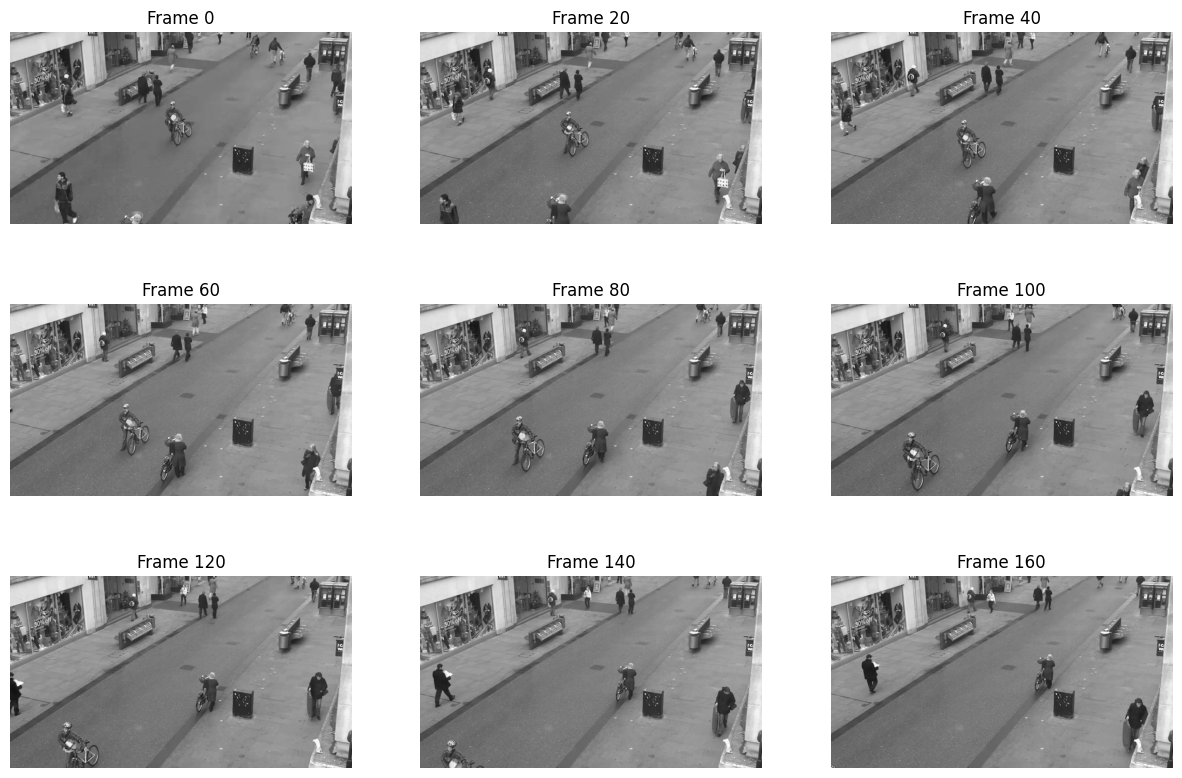

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

cap = cv2.VideoCapture('test.mp4')

# Read the first frame
ret, img0_color = cap.read()

# We work with grayscale images (range [0,1])
img0 = cv2.cvtColor(img0_color, cv2.COLOR_BGR2GRAY)/255
height, width = img0.shape

# Display and store a few frames
plt.figure(figsize=(15,10))
images = np.zeros((height,width,9), dtype=np.float32)

for i in range(9):

    cap.set(cv2.CAP_PROP_POS_FRAMES, 20*i)
    ret, img_color = cap.read()
    if ret == False:
        break

    img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)/255
    images[:,:,i] = img

    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.title('Frame %d' %(20*i))
    plt.axis('off')

cap.release()

## Initialization

Next we initialize the mean and variance images. For the mean image, we compute the median of the frames. This will give us the background without the moving objects. The camera noise can be estimated from any two frames. Here we assume that $\sigma_{rcam} = 0.005$.

(-0.5, 671.5, 377.5, -0.5)

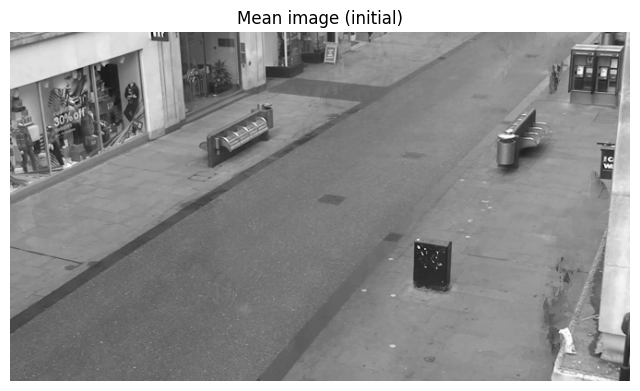

In [2]:
sigma_cam = 0.005
mean_img = np.median(images, axis=2)
var_img = sigma_cam * np.ones_like(img0)

# The current state is stored in a dictionary
state_initial = {"alpha": 0.99,
                 "sigma_cam": sigma_cam,
                 "mean_img": mean_img,
                 "var_img": var_img,
                 "K" : 2.0}

# You can access the values by
alpha = state_initial["alpha"] # Or: state_initial.get("alpha")

# And you can change the values by
state_initial["alpha"] = 0.99

# Show the mean image
plt.figure(figsize=(8,5))
plt.imshow(mean_img, cmap='gray')
plt.title('Mean image (initial)')
plt.axis('off')

## Task 1 - Update background model (1.0 points)

Implement the function `updateBackgroundModel` to update the mean and variance of the dynamic background model. The mean background image `state["mean_img"]` should be updated using Equation 1, and the variance `state["var_img"]` should be updated using Equation 2. Compute $\mu_{t+1}$ first, as Equation 2 requires both the previous mean $\mu_t$ and the updated mean $\mu_{t+1}$.

### Instructions
- Use **Equation 1** to update `state["mean_img"]`.
- Use **Equation 2** to update `state["var_img"]`.
- There is no need to use for-loops. Approximately 2-5 lines of code required.

In [11]:
# INPUT
# img   : The current grayscale image
# state : The current state (as define before)
#
# OUTPUT
# state : Updated state, where state["mean_img"] and
#         state["var_img"] have been updated.
#
def updateBackgroundModel(img, state):

    # ---------- YOUR CODE STARTS HERE -----------

    alpha = state["alpha"]
    old_mean = state["mean_img"]
    old_var = state["var_img"]

    state["mean_img"] = alpha * old_mean + (1 - alpha) * img
    state["var_img"] = alpha * (old_var + (state["mean_img"] - old_mean) ** 2) + (1 - alpha) * (img - state["mean_img"]) ** 2

    # ----------- YOUR CODE ENDS HERE ------------

    return state


# A sanity check. You are probably on the right track
# if the following prints approx. 0.505294 and 0.004984
state_test = state_initial.copy()
state_test = updateBackgroundModel(img0, state_test)
print(state_test["mean_img"][100,100])
print(state_test["var_img"][100,100])

0.5052941456121557
0.004984256089665909


In [ ]:
# LEAVE EMPTY

## Task 2 - Threshold frame (1.0 points)

Implement the function `thresholdFrame` to detect new objects in a frame using background subtraction. The function should apply Equation 3, which classifies pixels as foreground if they deviate significantly from the background model.

### Instructions
- Compute **$\sigma_t$** as the square root of the variance (`state["var_img"]`).
- Use **Equation 3** to determine which pixels belong to moving objects.
- Utilize the element-wise maximum operation __[`np.maximum`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.maximum.html)__.
- There is no need to use for-loops. Only a few lines of code required.

In [16]:
# INPUT
# img   : The current grayscale image
# state : The current state
#
# OUTPUT
# thresh : Thresholded image
#
def thresholdFrame(img, state):

    # ---------- YOUR CODE STARTS HERE -----------

    dev = np.sqrt(state["var_img"])
    thresh = (np.abs(img - state["mean_img"]) > (state["K"] * np.maximum(dev, state["sigma_cam"]))).astype(np.uint8) * 255

    # ----------- YOUR CODE ENDS HERE ------------

    return thresh

## Testing

Once you have completed the two functions, perform background subtraction on the provided video using the following code. The code will process the first N frames and display the result for the last frame. The output should look like Figure 1.

(-0.5, 671.5, 377.5, -0.5)

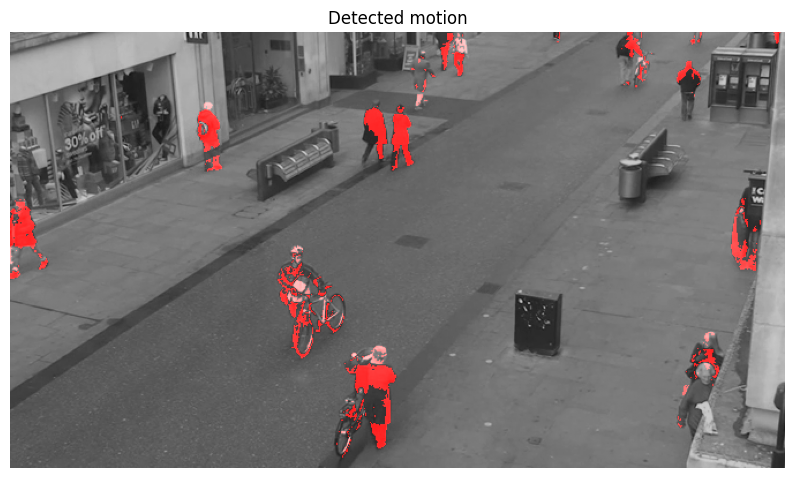

In [17]:
cap = cv2.VideoCapture('test.mp4')

N = 50
i = 0

state = state_initial.copy()

while i < N:

    ret, img_color = cap.read()
    if ret == False:
        break

    # Convert to grayscale
    img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)/255

    # Update
    state = updateBackgroundModel(img, state);

    i += 1

cap.release()

# Threshold
thresh = thresholdFrame(img, state);

# Overlay thresholded image on the frame
overlayed = np.stack((img,)*3, axis=-1)
red = img.copy()
red[thresh.astype("bool")] = 1
overlayed[:,:,0] = red

# Display
plt.figure(figsize=(10,7))
plt.imshow(overlayed)
plt.title('Detected motion')
plt.axis('off')

In [ ]:
# LEAVE EMPTY

**Generating output video (optional)**

In the following code cell, you can set `generate_video = True` to generate an output video showing the detected regions. Before submitting the assignment, please set `generate_video = False`.

In [ ]:
generate_video = False

if generate_video:

    cap = cv2.VideoCapture('test.mp4')

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (width,height))

    N = 500
    i = 0

    state = state_initial.copy()

    while i < N:

        ret, img_color = cap.read()
        if ret == False:
            break

        # Convert to grayscale
        img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)/255

        # Threshold
        thresh = thresholdFrame(img, state);

        # Update
        state = updateBackgroundModel(img, state);

        # Write output frame
        red = img_color[:,:,2]
        red[thresh.astype("bool")] = 255
        img_color[:,:,2] = red
        out.write(img_color)

        i += 1

    cap.release()
    out.release()


# Aftermath

Please provide short answers to the following questions:

**1. How much time did you need to complete this exercise?**

`REPLACE THIS TEXT WITH YOUR ANSWER.`

**2. Did you experience any issues or find anything particularly confusing?**

`REPLACE THIS TEXT WITH YOUR ANSWER.`


# References

`List any references here (optional).`

# Submission

1. Go to `Kernel -> Restart & Clear Output` to remove all outputs.
2. Compress this notebook (`MV_A6.ipynb`) into `MV_A6.zip`.
3. Submit the **zip** file on Moodle.

**Deadline: 23.02.2025**